In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Question 1

In [129]:
# read dataset function
def read_data(path):
    """
    Reads a CSV file at the given path, removes any duplicate rows,
    and returns its contents as a pandas DataFrame.

    Parameters
    ----------
    path : str
        The sample data input path (csv format)

    Return
    ------
    df : pd.DataFrame
        The sample data input
    """
    # Read data
    df = pd.read_csv(path)

    # Validate
    print('Data shape:', df.shape)

    return df

In [130]:
# Dataset name / Path
path = 'fraud_ecom_transaction_data.csv'

# Read the data
df_raw = read_data(path = path)
df_raw.drop(['Transaction ID'],axis='columns',inplace=True)

Data shape: (23634, 10)


In [131]:
df = df_raw.copy()

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction Amount  23634 non-null  float64
 1   Payment Method      23634 non-null  object 
 2   Product Category    23634 non-null  object 
 3   Quantity            23634 non-null  int64  
 4   Customer Age        23634 non-null  int64  
 5   Device Used         23634 non-null  object 
 6   Is Fraudulent       23634 non-null  int64  
 7   Account Age Days    23634 non-null  int64  
 8   Transaction Hour    23634 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.6+ MB


The data type seems okay.

In [133]:
# Inspect missing values
print(df.isnull().sum())

Transaction Amount    0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Device Used           0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64


There is no missing data

In [134]:
#Inspect Duplicates
print(f'there is {df.duplicated().sum()} duplicates')

# Drop duplicates (if any)
df = df.drop_duplicates()

there is 0 duplicates


In [135]:
df.describe()

,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000
mean,229.367099,3.000550,34.560210,0.051705,178.660531,11.266015
std,282.046669,1.419663,10.009471,0.221436,107.388682,6.980659
min,10.000000,1.000000,-2.000000,0.000000,1.000000,0.000000
25%,69.070000,2.000000,28.000000,0.000000,84.000000,5.000000
50%,151.415000,3.000000,35.000000,0.000000,178.000000,11.000000
75%,296.127500,4.000000,41.000000,0.000000,272.000000,17.000000
max,9716.500000,5.000000,73.000000,1.000000,365.000000,23.000000


There's anomalies in customer age , usually a person can do transaction around 6-7 years old. in this case using 7 years old minimum.

In [136]:
df[df['Customer Age']<=6].value_counts().sum()

63

You must be at least 18 years old or the age of majority in your country to open a PayPal account and credit card, for debit card i assume below 18 can use their parents card. so i want to check how many customer use paypal and credit card within the age. 

In [138]:
df[(df['Customer Age']<=17 )&(df['Payment Method']=='PayPal')].value_counts().sum()

251

In [139]:
df[(df['Customer Age']<=17 )&(df['Payment Method']=='credit card')].value_counts().sum()

270

because 584/23634 = 0.0247 or 2.5% considered small , we can drop the two conditions.

In [ ]:
df.drop(df[df['Customer Age']<=6].index,inplace=True)

In [140]:
#drop the paypal condition
df.drop(df[(df['Customer Age']<=17 )&(df['Payment Method']=='PayPal')].index,inplace=True)
#drop the credit card condition
df.drop(df[(df['Customer Age']<=17 )&(df['Payment Method']=='credit card')].index,inplace=True)

In [141]:
df['Payment Method'].unique()

array(['PayPal', 'credit card', 'debit card', 'bank transfer'],
      dtype=object)

In [142]:
df['Product Category'].unique()

array(['electronics', 'toys & games', 'clothing', 'home & garden',
       'health & beauty'], dtype=object)

In [143]:
df['Device Used'].unique()

array(['desktop', 'tablet', 'mobile'], dtype=object)

there is no inconsistencies in the data

In [144]:
df[df['Payment Method']=='bank transfer'].sort_values(by='Customer Age')

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour
12405,35.22,bank transfer,health & beauty,2,7,desktop,0,318,6
13240,89.99,bank transfer,clothing,2,7,tablet,0,33,8
15026,42.73,bank transfer,toys & games,2,7,mobile,0,195,15
21347,347.79,bank transfer,toys & games,3,7,tablet,0,166,6
1325,184.86,bank transfer,electronics,1,7,desktop,0,42,5
...,...,...,...,...,...,...,...,...,...
7801,115.89,bank transfer,home & garden,5,65,mobile,1,337,9
6968,532.14,bank transfer,clothing,5,65,tablet,0,48,5
15679,49.56,bank transfer,home & garden,2,66,desktop,0,289,18
4231,382.03,bank transfer,electronics,4,66,desktop,0,275,1


In [145]:
# function split input and output
def split_input_output(data, target_column):
    """
    Function to split input (x) and output (y)

    Parameters
    ----------
    data : pd.DataFrame
        The sample data input

    target_column : str
        The output column name

    Return
    ------
    X : pd.DataFrame
        input data

    y : pd.DataFrame
        output data
    """
    X = data.drop(columns = target_column)
    y = data[target_column]

    # Validate
    print('X shape:', X.shape)
    print('y shape :', y.shape)

    return X, y

In [146]:
# Split input x and output y
X, y = split_input_output(data = df,
                          target_column = "Is Fraudulent")

X shape: (23050, 8)
y shape : (23050,)


In [147]:
def split_train_test(X,y, test_size, random_state=42):
    """
    Split data into train & test

    Parameters
    ----------
    X : pd.DataFrame
        The input data
    test_size : float
        The proportion of number of test data to total data

    stratify : pd.Series
        Reference to stratify the splitting

    random_state : int, default=42
        The random seed, for reproducibility

    Returns
    -------
    X_train : pd.DataFrame
        The input train data

    X_test : pd.DataFrame
        The input test data
    """

    # Then, split train and test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    # Then split temp into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Train set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [148]:
splitted_data = split_train_test(
    X = X,
    y=y,
    test_size = 0.4,
    random_state = 42
)

X_train, X_val, X_test, y_train, y_val, y_test = splitted_data

Train set size: 13830
Validation set size: 4610
Test set size: 4610


# Question 2

In [149]:
def perform_eda(df):
    # 1. Check class distribution
    fraud_count = df['Is Fraudulent'].sum()
    total_count = len(df)
    print(f"Fraudulent transactions: {fraud_count} ({fraud_count/total_count:.2%})")
    print(f"Legitimate transactions: {total_count - fraud_count} ({(total_count - fraud_count)/total_count:.2%})")
    
    plt.figure(figsize=(16, 14))
    
    # 1. Transaction Amount Distribution by Fraud Status (Histogram)
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Transaction Amount', hue='Is Fraudulent', bins=30, kde=True)
    plt.title('Transaction Amount Distribution by Fraud Status')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Count')
    
    # 2. Customer Age Distribution by Fraud Status (Boxplot)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Is Fraudulent', y='Customer Age')
    plt.title('Customer Age Distribution by Fraud Status')
    plt.xlabel('Is Fraudulent')
    plt.ylabel('Customer Age')
    
    # 3. Transaction Amount by Fraud Status (Boxplot)
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df, x='Is Fraudulent', y='Transaction Amount')
    plt.title('Transaction Amount by Fraud Status')
    plt.xlabel('Is Fraudulent')
    plt.ylabel('Transaction Amount')
    
    # 4. Fraud Rate by Payment Method (Bar Chart)
    plt.subplot(2, 2, 4)
    fraud_by_payment = df.groupby('Payment Method')['Is Fraudulent'].mean().sort_values(ascending=False)
    sns.barplot(x=fraud_by_payment.index, y=fraud_by_payment.values)
    plt.title('Fraud Rate by Payment Method')
    plt.xlabel('Payment Method')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualizations
    plt.figure(figsize=(16, 14))
    
    # 5. Fraud Rate by Device Used
    plt.subplot(2, 2, 1)
    fraud_by_device = df.groupby('Device Used')['Is Fraudulent'].mean().sort_values(ascending=False)
    sns.barplot(x=fraud_by_device.index, y=fraud_by_device.values)
    plt.title('Fraud Rate by Device Used')
    plt.xlabel('Device Used')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    
    # 6. Fraud Rate by Product Category
    plt.subplot(2, 2, 2)
    fraud_by_category = df.groupby('Product Category')['Is Fraudulent'].mean().sort_values(ascending=False)
    sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values)
    plt.title('Fraud Rate by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    
    # 7. Transaction Hour Distribution by Fraud Status
    plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='Transaction Hour', hue='Is Fraudulent', bins=24, kde=True)
    plt.title('Transaction Hour Distribution by Fraud Status')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    
    # 8. Account Age Distribution by Fraud Status
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='Is Fraudulent', y='Account Age Days')
    plt.title('Account Age Distribution by Fraud Status')
    plt.xlabel('Is Fraudulent')
    plt.ylabel('Account Age (Days)')
    
    plt.tight_layout()
    plt.show()
    # Correlation analysis
    plt.figure(figsize=(10, 8))
    numerical_columns = ['Transaction Amount', 'Quantity', 'Customer Age', 
                         'Account Age Days', 'Transaction Hour', 'Is Fraudulent']
    correlation = df[numerical_columns].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return fraud_by_payment, fraud_by_device, fraud_by_category

Fraudulent transactions: 1198 (5.20%)
Legitimate transactions: 21852 (94.80%)


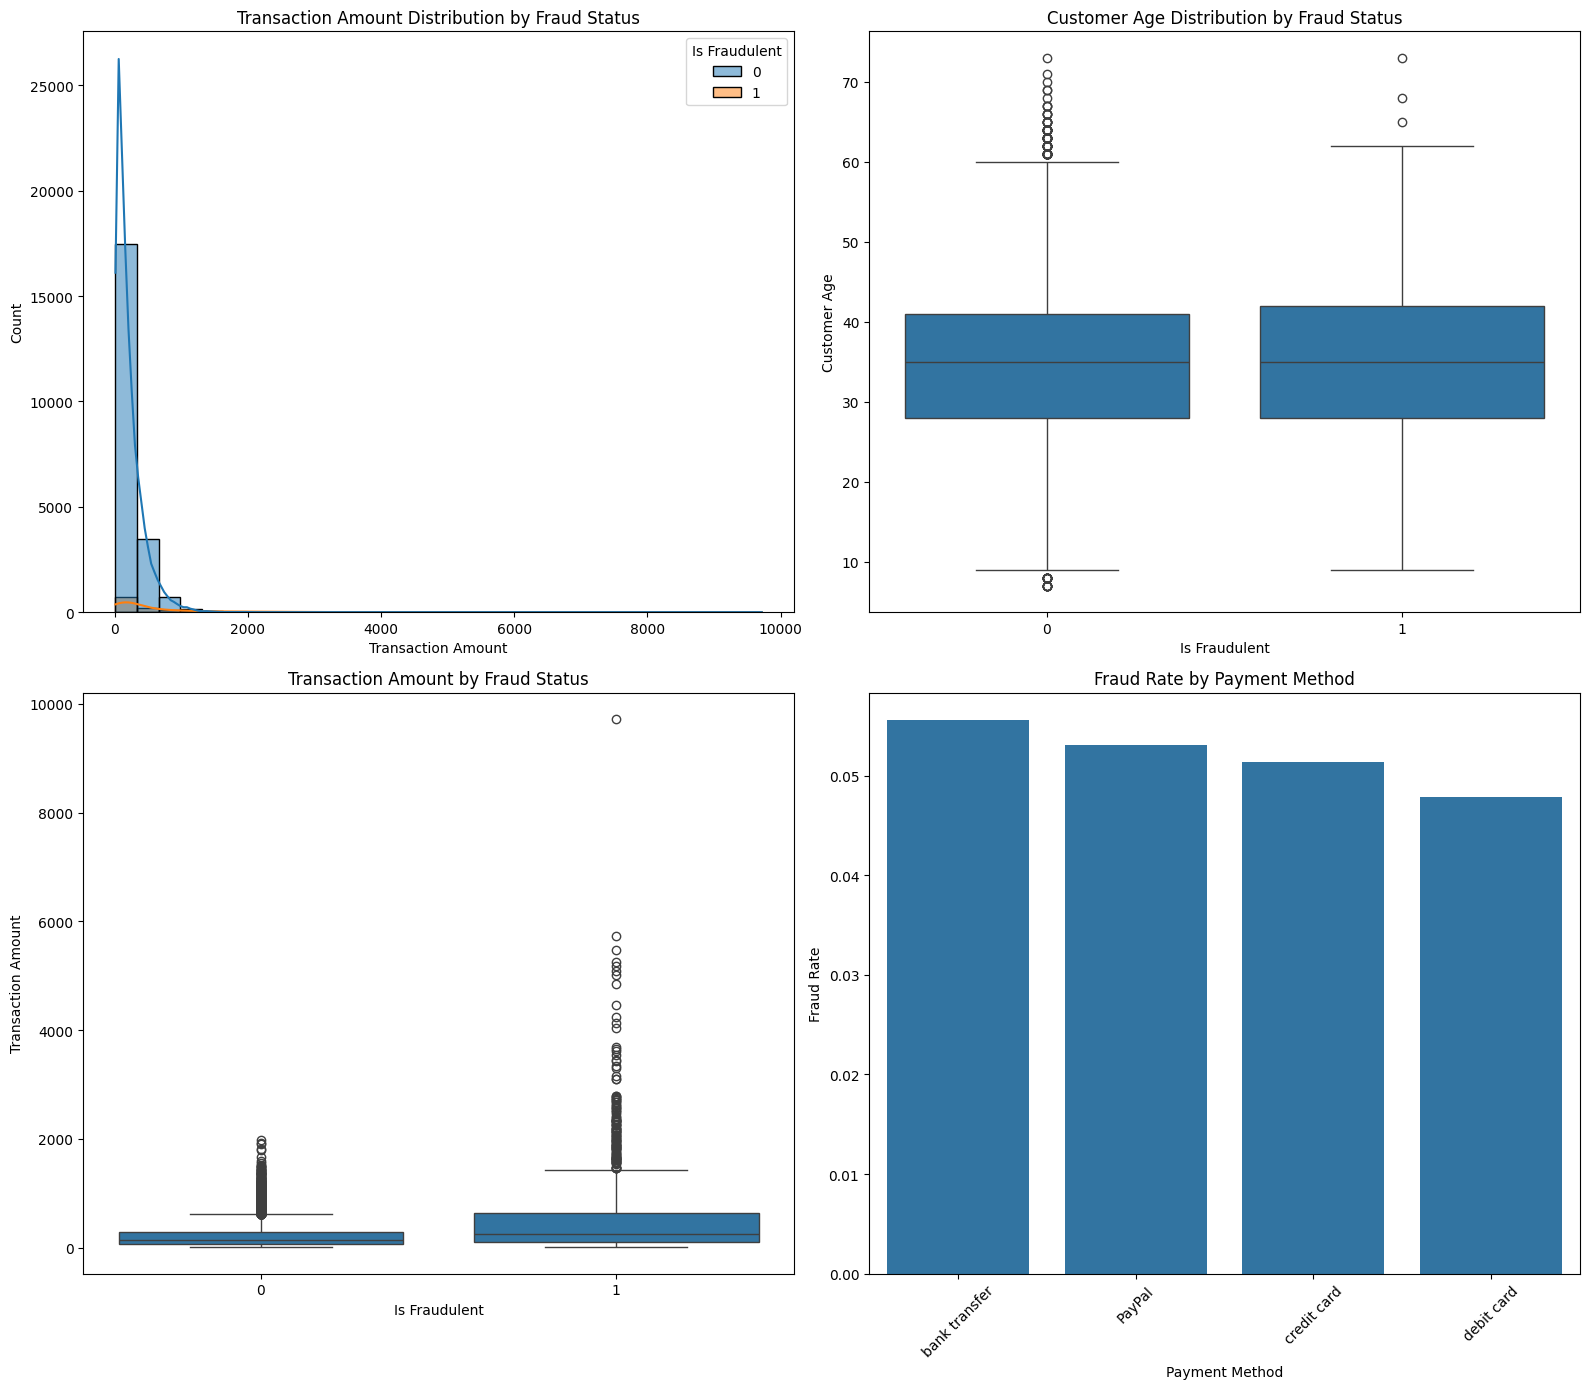

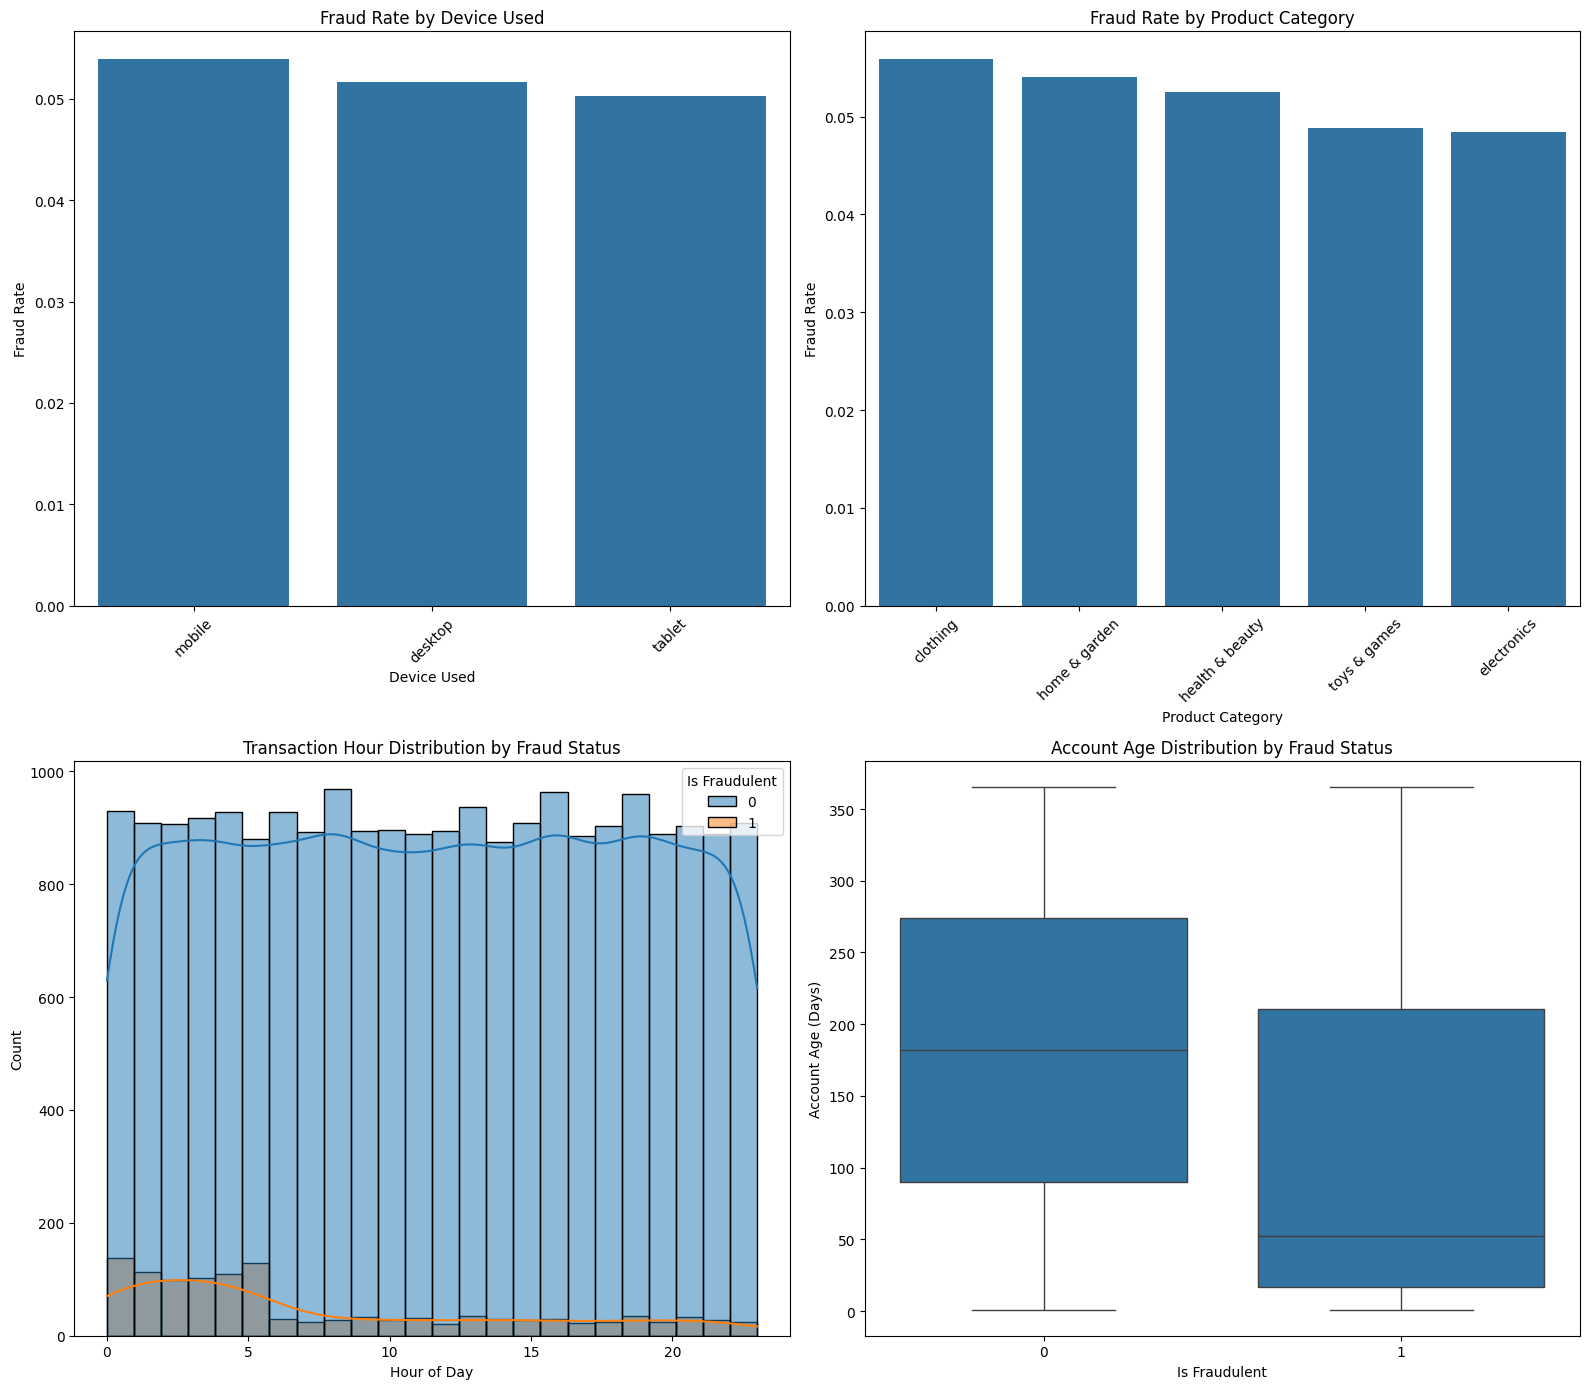

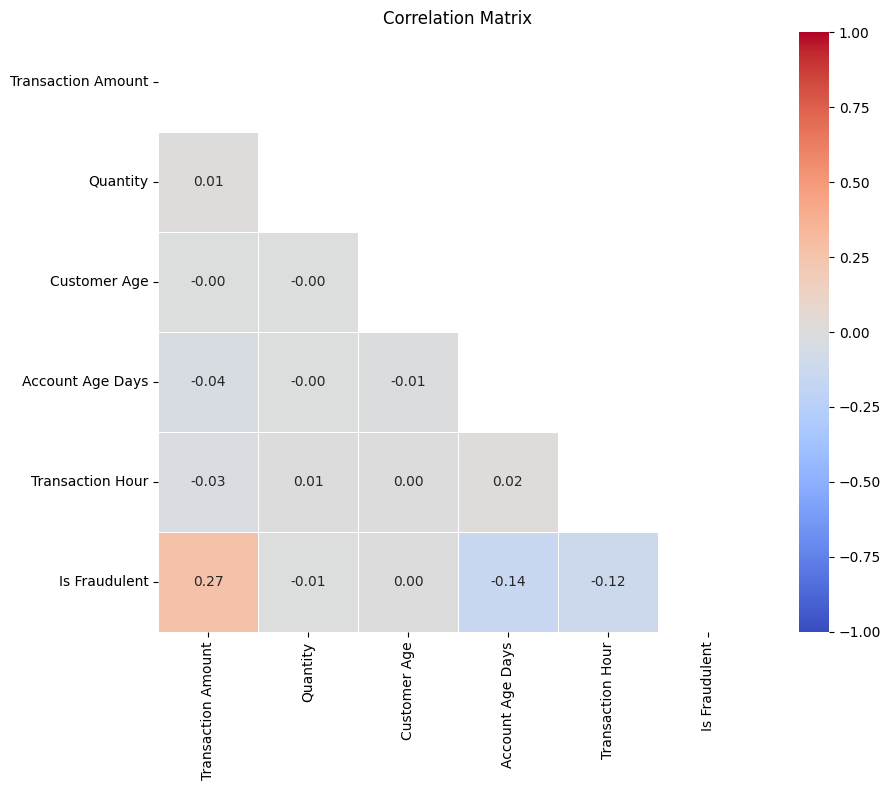

(Payment Method
 bank transfer    0.055575
 PayPal           0.053118
 credit card      0.051428
 debit card       0.047860
 Name: Is Fraudulent, dtype: float64,
 Device Used
 mobile     0.053973
 desktop    0.051653
 tablet     0.050282
 Name: Is Fraudulent, dtype: float64,
 Product Category
 clothing           0.055932
 home & garden      0.054083
 health & beauty    0.052562
 toys & games       0.048844
 electronics        0.048474
 Name: Is Fraudulent, dtype: float64)

In [150]:
perform_eda(df)

### Key insights
Key Insights from EDA:
1. Fraudulent transactions (orange) appear to have a slightly higher average amount than legitimate ones (blue), though they're still primarily in the lower range. Fraudsters may attempt both numerous smaller transactions and occasional very large ones.

2. The fraud rate seems relatively consistent across payment methods, though slightly higher in bank transfers based on the proportion.

3. While the differences aren't large, fraudsters appear to slightly prefer mobile devices, possibly due to their portability and ease of use for quick transactions.

4. Product categories (especially clothing) might be more attractive targets for fraudsters, possibly due to ease of resale or return policies.

5. The pattern shows that potential frauds attempts are in 0-5 am which the security is less monitored.

6. This strongly indicates that newer accounts warrant is a potential fraud.

7. The strongest correlations with fraud are observed with account age (newer accounts), transaction amount (higher amounts), and transaction timing (early morning hours), while customer age shows virtually no correlation with fraudulent activity.

# Question 3

In [151]:
numerical_features = ['Transaction Amount', 'Quantity', 'Customer Age', 
                          'Account Age Days', 'Transaction Hour']
categorical_features = ['Payment Method', 'Product Category', 'Device Used']
response_variable = "Is Fraudulent"

In [152]:
# Create a function for binning the numerical predictor
def create_binning(data, predictor_label, num_of_bins):
    """
    Function for binning numerical predictor.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    num_of_bins : integer
      The number of bins.


    Return
    ------
    data : array like
      The name of transformed dataset.

    """
    # Create a new column containing the binned predictor
    data[predictor_label + "_bin"] = pd.qcut(data[predictor_label],
                                             q = num_of_bins,
                                             duplicates = "drop")

    return data

In [153]:
for column in numerical_features:
    data_train_binned = create_binning(data = df,
                                       predictor_label = column,
                                       num_of_bins = 4)

In [154]:
# Define the initial empty list
crosstab_num = []

for column in numerical_features:
  # Create a contingency table
  crosstab = pd.crosstab(data_train_binned[column + "_bin"],
                         data_train_binned[response_variable],
                         margins = True)
  # Append to the list
  crosstab_num.append(crosstab)


# Define the initial empty list
crosstab_cat = []

for column in categorical_features:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_binned[column],
                         data_train_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_cat.append(crosstab)

# Put all two in a crosstab_list
crosstab_list = crosstab_num + crosstab_cat

for i in crosstab_list:
    display(i)

Is Fraudulent,0,1,All
Transaction Amount_bin,,,
"(9.999, 69.07]",5589,176,5765
"(69.07, 151.5]",5516,245,5761
"(151.5, 295.66]",5520,242,5762
"(295.66, 9716.5]",5227,535,5762
All,21852,1198,23050


Is Fraudulent,0,1,All
Quantity_bin,,,
"(0.999, 2.0]",8762,513,9275
"(2.0, 3.0]",4355,203,4558
"(3.0, 4.0]",4265,250,4515
"(4.0, 5.0]",4470,232,4702
All,21852,1198,23050


Is Fraudulent,0,1,All
Customer Age_bin,,,
"(6.999, 28.0]",5506,302,5808
"(28.0, 35.0]",5929,328,6257
"(35.0, 42.0]",5666,289,5955
"(42.0, 73.0]",4751,279,5030
All,21852,1198,23050


Is Fraudulent,0,1,All
Account Age Days_bin,,,
"(0.999, 84.0]",5120,655,5775
"(84.0, 178.0]",5600,185,5785
"(178.0, 272.0]",5558,185,5743
"(272.0, 365.0]",5574,173,5747
All,21852,1198,23050


Is Fraudulent,0,1,All
Transaction Hour_bin,,,
"(-0.001, 5.0]",5472,688,6160
"(5.0, 11.0]",5466,174,5640
"(11.0, 17.0]",5462,166,5628
"(17.0, 23.0]",5452,170,5622
All,21852,1198,23050


Is Fraudulent,0,1,All
Payment Method,,,
PayPal,5330,299,5629
bank transfer,5523,325,5848
credit card,5349,290,5639
debit card,5650,284,5934
All,21852,1198,23050


Is Fraudulent,0,1,All
Product Category,,,
clothing,4321,256,4577
electronics,4397,224,4621
health & beauty,4308,239,4547
home & garden,4425,253,4678
toys & games,4401,226,4627
All,21852,1198,23050


Is Fraudulent,0,1,All
Device Used,,,
desktop,7344,400,7744
mobile,7274,415,7689
tablet,7234,383,7617
All,21852,1198,23050


In [155]:
# Define the initial list for WOE
WOE_list = []

# Define the initial list for IV
IV_list = []

# Perform the algorithm for all crosstab
for crosstab in crosstab_list:

  # Calculate % Good
  crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

  # Calculate % Bad
  crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

  # Calculate the WOE
  crosstab['WOE'] = np.log(crosstab['p_good']/(crosstab['p_bad'] + 1e-6))  # add 1e-6 to prevent 0 division

  # Calculate the contribution value for IV
  crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']

  # Calculate the IV
  IV = crosstab['contribution'][:-1].sum()
  add_IV = {'Characteristic': crosstab.index.name,
            'Information Value': IV}

  WOE_list.append(crosstab)
  IV_list.append(add_IV)

for i in WOE_list:
    display(i)

Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Transaction Amount_bin,,,,,,,
"(9.999, 69.07]",5589,176,5765,0.255766,0.146912,5.544259e-01,0.060352
"(69.07, 151.5]",5516,245,5761,0.252425,0.204508,2.105062e-01,0.010087
"(151.5, 295.66]",5520,242,5762,0.252608,0.202003,2.235515e-01,0.011313
"(295.66, 9716.5]",5227,535,5762,0.239200,0.446578,-6.243152e-01,0.129469
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Quantity_bin,,,,,,,
"(0.999, 2.0]",8762,513,9275,0.400970,0.428214,-6.573766e-02,0.001791
"(2.0, 3.0]",4355,203,4558,0.199295,0.169449,1.622291e-01,0.004842
"(3.0, 4.0]",4265,250,4515,0.195177,0.208681,-6.690720e-02,0.000904
"(4.0, 5.0]",4470,232,4702,0.204558,0.193656,5.476220e-02,0.000597
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Customer Age_bin,,,,,,,
"(6.999, 28.0]",5506,302,5808,0.251968,0.252087,-4.762494e-04,5.668705e-08
"(28.0, 35.0]",5929,328,6257,0.271325,0.273790,-9.045368e-03,2.229114e-05
"(35.0, 42.0]",5666,289,5955,0.259290,0.241235,7.216890e-02,1.302964e-03
"(42.0, 73.0]",4751,279,5030,0.217417,0.232888,-6.874463e-02,1.063547e-03
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000e+00


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Account Age Days_bin,,,,,,,
"(0.999, 84.0]",5120,655,5775,0.234303,0.546745,-8.473663e-01,0.264752
"(84.0, 178.0]",5600,185,5785,0.256269,0.154424,5.065206e-01,0.051587
"(178.0, 272.0]",5558,185,5743,0.254347,0.154424,4.989924e-01,0.049861
"(272.0, 365.0]",5574,173,5747,0.255080,0.144407,5.689307e-01,0.062965
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Transaction Hour_bin,,,,,,,
"(-0.001, 5.0]",5472,688,6160,0.250412,0.574290,-8.300301e-01,0.268829
"(5.0, 11.0]",5466,174,5640,0.250137,0.145242,5.436012e-01,0.057021
"(11.0, 17.0]",5462,166,5628,0.249954,0.138564,5.899363e-01,0.065713
"(17.0, 23.0]",5452,170,5622,0.249497,0.141903,5.642934e-01,0.060714
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Payment Method,,,,,,,
PayPal,5330,299,5629,0.243914,0.249583,-2.298001e-02,0.000130
bank transfer,5523,325,5848,0.252746,0.271285,-7.079135e-02,0.001312
credit card,5349,290,5639,0.244783,0.242070,1.114090e-02,0.000030
debit card,5650,284,5934,0.258558,0.237062,8.679342e-02,0.001866
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Product Category,,,,,,,
clothing,4321,256,4577,0.197739,0.213689,-7.757894e-02,0.001237
electronics,4397,224,4621,0.201217,0.186978,7.338742e-02,0.001045
health & beauty,4308,239,4547,0.197144,0.199499,-1.187848e-02,0.000028
home & garden,4425,253,4678,0.202499,0.211185,-4.200762e-02,0.000365
toys & games,4401,226,4627,0.201400,0.188648,6.540782e-02,0.000834
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


Is Fraudulent,0,1,All,p_good,p_bad,WOE,contribution
Device Used,,,,,,,
desktop,7344,400,7744,0.336079,0.333890,6.532439e-03,0.000014
mobile,7274,415,7689,0.332876,0.346411,-3.985873e-02,0.000539
tablet,7234,383,7617,0.331045,0.319699,3.487034e-02,0.000396
All,21852,1198,23050,1.000000,1.000000,-9.999995e-07,-0.000000


In [156]:
# Put all IV in the table
IV_table = pd.DataFrame(IV_list)

IV_table

,Characteristic,Information Value
0,Transaction Amount_bin,0.211221
1,Quantity_bin,0.008133
2,Customer Age_bin,0.002389
3,Account Age Days_bin,0.429165
4,Transaction Hour_bin,0.452277
5,Payment Method,0.003339
6,Product Category,0.003509
7,Device Used,0.000949


In [157]:
# Define the predictive power of each characteristic
strength = []

# Assign the rule of thumb regarding IV
for iv in IV_table['Information Value']:
    if iv <= 0.1 :
        strength.append('Very Weak')
    elif iv >= 0.1 and iv < 0.3:
        strength.append('Weak')
    else:
        strength.append('Strong')

# Assign the strength to each characteristic
IV_table = IV_table.assign(Strength = strength)

# Sort the table by the IV values
IV_table.sort_values(by='Information Value')

,Characteristic,Information Value,Strength
7,Device Used,0.000949,Very Weak
2,Customer Age_bin,0.002389,Very Weak
5,Payment Method,0.003339,Very Weak
6,Product Category,0.003509,Very Weak
1,Quantity_bin,0.008133,Very Weak
0,Transaction Amount_bin,0.211221,Weak
3,Account Age Days_bin,0.429165,Strong
4,Transaction Hour_bin,0.452277,Strong


We have:
- 5 Very Weak
- 1 Weak
- 2 strong characteristics

# Question 4

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

From the EDA and WOE, Transaction Hour,Transaction Amount, and Account Age Days will be variable to make our fraud model.

In [159]:
top_features =['Transaction Hour','Transaction Amount','Account Age Days']

In [160]:
def build_simple_model(X_train, X_val, y_train, y_val, top_features):
    # Select only the top features
    X_train_selected = X_train[top_features].copy()
    X_val_selected = X_val[top_features].copy()
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_val_scaled = scaler.transform(X_val_selected)
    
    # Build logistic regression model
    lr_model = LogisticRegression(random_state=42)
    lr_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_val_pred = lr_model.predict(X_val_scaled)
    y_val_prob = lr_model.predict_proba(X_val_scaled)[:, 1]
    
    # Evaluate the model
    print("\nLogistic Regression Model with Top Features:")
    print(classification_report(y_val, y_val_pred))
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_val, y_val_prob)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Interpret the model
    coef_df = pd.DataFrame({
        'Feature': top_features,
        'Coefficient': lr_model.coef_[0]
    })
    coef_df = coef_df.sort_values('Coefficient', ascending=False)
    
    print("\nFeature Importance:")
    for index, row in coef_df.iterrows():
        if row['Coefficient'] > 0:
            print(f"- An increase in '{row['Feature']}' increases the probability of fraud (coef: {row['Coefficient']:.4f})")
        else:
            print(f"- An increase in '{row['Feature']}' decreases the probability of fraud (coef: {row['Coefficient']:.4f})")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Feature Importance in Logistic Regression Model')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.savefig('feature_importance.png')
    plt.close()
    
    return lr_model, scaler

In [161]:
build_simple_model(X_train,X_val,y_train,y_val,top_features)


Logistic Regression Model with Top Features:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4370
           1       0.81      0.14      0.24       240

    accuracy                           0.95      4610
   macro avg       0.88      0.57      0.61      4610
weighted avg       0.95      0.95      0.94      4610

ROC AUC: 0.7780

Feature Importance:
- An increase in 'Transaction Amount' increases the probability of fraud (coef: 0.6867)
- An increase in 'Account Age Days' decreases the probability of fraud (coef: -0.6621)
- An increase in 'Transaction Hour' decreases the probability of fraud (coef: -0.6717)


(LogisticRegression(random_state=42), StandardScaler())

### Key insights
Key Insights from Logistic Model:

1. The model has good precision (0.81) when it does flag fraud, meaning relatively few false positives.

2. The three identified features align with the visual analysis and provide a solid foundation for fraud detection 

3. The dataset is highly imbalanced , because all legitimate transactions correctly identified (recall class 0 is 1).

# Question 5

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [163]:
# Question 5: Alternative Models
def build_alternative_models(X_train, X_val, y_train, y_val,top_features):
    # Select only the top features
    X_train_selected = X_train[top_features].copy()
    X_val_selected = X_val[top_features].copy()
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_val_scaled = scaler.transform(X_val_selected)
    
    # 1. Logistic Regression with hyperparameter tuning
    print("\nLogistic Regression with Hyperparameter Tuning:")
    lr_params = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='roc_auc')
    lr_grid.fit(X_train_scaled, y_train)
    print(f"Best parameters: {lr_grid.best_params_}")
    
    # Evaluate tuned logistic regression
    lr_best = lr_grid.best_estimator_
    y_val_pred_lr = lr_best.predict(X_val_scaled)
    y_val_prob_lr = lr_best.predict_proba(X_val_scaled)[:, 1]
    lr_auc = roc_auc_score(y_val, y_val_prob_lr)
    print(f"Logistic Regression ROC AUC: {lr_auc:.4f}")
    
    # 2. Decision Tree with hyperparameter tuning
    print("\nDecision Tree with Hyperparameter Tuning:")
    dt_params = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='roc_auc')
    dt_grid.fit(X_train_selected, y_train)  # No need to scale for decision trees
    print(f"Best parameters: {dt_grid.best_params_}")
    
    # Evaluate tuned decision tree
    dt_best = dt_grid.best_estimator_
    y_val_pred_dt = dt_best.predict(X_val_selected)
    y_val_prob_dt = dt_best.predict_proba(X_val_selected)[:, 1]
    dt_auc = roc_auc_score(y_val, y_val_prob_dt)
    print(f"Decision Tree ROC AUC: {dt_auc:.4f}")
    
    # 3. Random Forest with hyperparameter tuning
    print("\nRandom Forest with Hyperparameter Tuning:")
    rf_params = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc')
    rf_grid.fit(X_train_selected, y_train)  # No need to scale for random forests
    print(f"Best parameters: {rf_grid.best_params_}")
    
    # Evaluate tuned random forest
    rf_best = rf_grid.best_estimator_
    y_val_pred_rf = rf_best.predict(X_val_selected)
    y_val_prob_rf = rf_best.predict_proba(X_val_selected)[:, 1]
    rf_auc = roc_auc_score(y_val, y_val_prob_rf)
    print(f"Random Forest ROC AUC: {rf_auc:.4f}")
    
    # Compare models
    print("\nModel Comparison:")
    models = {
        'Logistic Regression': (lr_best, lr_auc, y_val_prob_lr),
        'Decision Tree': (dt_best, dt_auc, y_val_prob_dt),
        'Random Forest': (rf_best, rf_auc, y_val_prob_rf)
    }
    
    for name, (model, auc, _) in models.items():
        print(f"{name}: ROC AUC = {auc:.4f}")
    
    # Identify best model
    best_model_name = max(models.items(), key=lambda x: x[1][1])[0]
    best_model = models[best_model_name][0]
    print(f"\nBest model based on validation ROC AUC: {best_model_name}")
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for name, (_, _, y_val_prob) in models.items():
        fpr, tpr, _ = roc_curve(y_val, y_val_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {models[name][1]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend(loc='lower right')
    plt.show()
    
    return models, best_model_name, scaler


Logistic Regression with Hyperparameter Tuning:
Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression ROC AUC: 0.7780

Decision Tree with Hyperparameter Tuning:
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Decision Tree ROC AUC: 0.8249

Random Forest with Hyperparameter Tuning:
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Random Forest ROC AUC: 0.8319

Model Comparison:
Logistic Regression: ROC AUC = 0.7780
Decision Tree: ROC AUC = 0.8249
Random Forest: ROC AUC = 0.8319

Best model based on validation ROC AUC: Random Forest


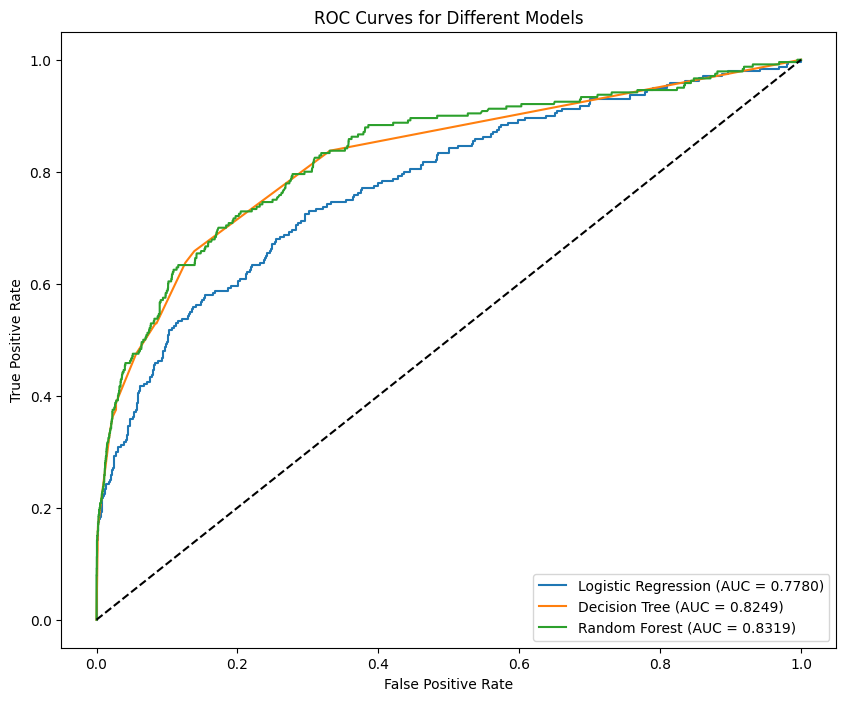

({'Logistic Regression': (LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear'),
   0.7780339435545385,
   array([0.04409037, 0.17327214, 0.03256078, ..., 0.03913533, 0.04241851,
          0.00599294])),
  'Decision Tree': (DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                          random_state=42),
   0.8248603165522501,
   array([0.0490086 , 0.16618076, 0.01280036, ..., 0.01280036, 0.01280036,
          0.01280036])),
  'Random Forest': (RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                          n_estimators=50, random_state=42),
   0.8319441266209,
   array([0.05158447, 0.1565653 , 0.02015245, ..., 0.01690502, 0.01895786,
          0.0154566 ]))},
 'Random Forest',
 StandardScaler())

In [164]:
build_alternative_models(X_train,X_val,y_train,y_val,top_features)

Based on the model comparison data provided, the Random Forest model is the best performing technique for this fraud detection task. The reason :

1. **Higher ROC AUC Score**: Random Forest achieved the highest ROC AUC score of 0.8319, outperforming both Decision Tree (0.8249) and Logistic Regression (0.7780). The ROC AUC metric is particularly valuable for imbalanced classification problems like fraud detection as it measures the model's ability to distinguish between classes regardless of the threshold chosen.

2. **Ensemble Advantage**: As an ensemble method, Random Forest combines multiple decision trees (50 in this case based on the best parameters), which helps reduce overfitting compared to a single decision tree. The modest improvement over the Decision Tree model (0.007 in AUC) suggests this ensemble effect is providing additional predictive power.

3. The tuned Random Forest uses a relatively shallow tree depth (max_depth: 5) and modest number of trees (n_estimators: 50), suggesting a good balance between model complexity and generalization ability.

# Question 6

In [165]:
# Select only the top features
X_train_selected = X_train[top_features].copy()
X_test_selected = X_test[top_features].copy()
    
# Build logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected,y_train)
# Get probabilities
y_prob = lr_model.predict_proba(X_test_selected)[:, 1]
    
# Test different thresholds
thresholds = [0.3, 0.5, 0.7]
results = []

# Create a DataFrame for the predicted probabilities
predictions_df = pd.DataFrame({
    'Predicted Probability': y_prob,
    'Actual': y_test.values  # Ensure y_val is a numpy array for alignment
})

# Add the Transaction Amount from X_val to the predictions DataFrame
predictions_df['Transaction Amount'] = X_test['Transaction Amount'].values


In [166]:
for threshold in thresholds:
    # Classify based on the threshold
    predictions_df['Predicted'] = (predictions_df['Predicted Probability'] >= threshold).astype(int)

    # Calculate FN Cost: Total amount of money exchanged in transactions for ignored fraud cases
    fn_cost = predictions_df.loc[(predictions_df['Predicted'] == 0) & (predictions_df['Actual'] == 1), 'Transaction Amount'].sum()

    # Calculate FP Cost: Losses from profit (5% of the total amount) and customer acquisition costs ($15 per customer)
    fp_cost = predictions_df.loc[(predictions_df['Predicted'] == 1) & (predictions_df['Actual'] == 0), 'Transaction Amount'].sum() * 0.05 + \
               np.sum((predictions_df['Predicted'] == 1) & (predictions_df['Actual'] == 0)) * 15

    total_cost = fn_cost + fp_cost
    results.append((threshold, fn_cost, fp_cost, total_cost))

results_df = pd.DataFrame(results, columns=['Threshold', 'FN Cost', 'FP Cost', 'Total Cost'])
print(results_df)

   Threshold   FN Cost   FP Cost  Total Cost
0        0.3  40306.71  2391.457   42698.167
1        0.5  53309.69   783.924   54093.614
2        0.7  67268.88     0.000   67268.880


Based on the threshold tuning data aboved, if the output is to ensure that all fraud cases are caught (minimizing false negatives), the optimal threshold is 0.3. The reason :

1. False Negative (FN) Cost: The 0.3 threshold has the lowest FN Cost at $40,306.71, meaning it misses the fewest fraud cases or their monetary value is lowest.

2. Trade-off Context: While the 0.3 threshold does increase False Positive (FP) Cost to $2,391.46 (cases incorrectly flagged as fraud), this is a reasonable trade-off when the priority is catching all fraud.

3. Total Cost Perspective: Even with the higher FP Cost, the 0.3 threshold still yields the lowest Total Cost ($42,698.17) among all options, making it optimal from both a fraud-detection and overall cost perspective.

The other thresholds show this trade-off clearly:

At 0.5: FN Cost increases by ~$13,000 while FP Cost decreases by ~$1,600

At 0.7: FN Cost increases further to $67,268.88 with FP Cost reaching zero (no false positives)

When fraud detection is the absolute priority, the 0.3 threshold provides the best balance by minimizing missed fraud cases while keeping the overall cost impact lowest.

# Question 7

In [167]:
# Import DummyClassifier from Sklearn Library
from sklearn.dummy import DummyClassifier
base_clf = DummyClassifier(strategy = "most_frequent")

# Fit model on Train data
base_clf.fit(X_train_selected, y_train)
y_pred = base_clf.predict(X_test_selected).astype(int)

In [171]:
results_base = []
predictions_df_base = pd.DataFrame({
    'Predicted Probability': y_pred,
    'Actual': y_test.values  # Ensure y_val is a numpy array for alignment
})

# Add the Transaction Amount from X_val to the predictions DataFrame
predictions_df_base['Transaction Amount'] = X_test['Transaction Amount'].values


In [172]:
# Calculate FN Cost: Total amount of money exchanged in transactions for ignored fraud cases
fn_cost = predictions_df_base.loc[(predictions_df_base['Predicted Probability'] == 0) & (predictions_df_base['Actual'] == 1), 'Transaction Amount'].sum()

# Calculate FP Cost: Losses from profit (5% of the total amount) and customer acquisition costs ($15 per customer)
fp_cost = predictions_df.loc[(predictions_df_base['Predicted Probability'] == 1) & (predictions_df_base['Actual'] == 0), 'Transaction Amount'].sum() * 0.05 + \
         np.sum((predictions_df_base['Predicted Probability'] == 1) & (predictions_df_base['Actual'] == 0)) * 15

total_cost = fn_cost + fp_cost
results_base.append((fn_cost, fp_cost, total_cost))

results_df_base = pd.DataFrame(results_base, columns=['FN Cost', 'FP Cost', 'Total Cost'],index=['Baseline Model'])
print(results_df_base)

                  FN Cost  FP Cost  Total Cost
Baseline Model  121283.88      0.0   121283.88


In [174]:
data = [
    {'FN Cost': 121283.88, 'FP Cost': 0.0, 'Total Cost': 121283.88},
    {'FN Cost': 40306.71, 'FP Cost': 2391.457, 'Total Cost': 42698.167}
]

model_summary = pd.DataFrame(data, index=['Baseline Model', 'Logistic Regression with 0.3 Threshold'])
print(model_summary)

                                          FN Cost   FP Cost  Total Cost
Baseline Model                          121283.88     0.000  121283.880
Logistic Regression with 0.3 Threshold   40306.71  2391.457   42698.167


In summary, the logistic regression with 0.3 threshold model represents a major improvement over the baseline approach and demonstrates how explicitly modeling the financial impact of classification decisions can lead to better business outcomes in fraud detection.

# Question 8

In [175]:
# 1. Extract classification metrics from your Random Forest model
# Assuming you have predictions from your best model (Random Forest)

rf_params = {
        'n_estimators': [50],
        'max_depth': [5],
        'min_samples_split': [5],
        'min_samples_leaf': [2]
    }
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc')
rf_model.fit(X_train_selected, y_train)  # No need to scale for random forests
y_true = y_test  # Actual fraud labels
y_pred = rf_model.predict(X_test_selected)  # Predicted labels
y_prob = rf_model.predict_proba(X_test_selected)[:, 1]  # Probability scores

# 2. Apply threshold if you're using custom threshold
threshold = 0.3  # Or whatever threshold you determined is optimal
y_pred_threshold = (y_prob >= threshold).astype(int)

# 3. Identify different classification categories
tp_mask = (y_pred_threshold == 1) & (y_true == 1)  # True Positives
tn_mask = (y_pred_threshold == 0) & (y_true == 0)  # True Negatives
fp_mask = (y_pred_threshold == 1) & (y_true == 0)  # False Positives
fn_mask = (y_pred_threshold == 0) & (y_true == 1)  # False Negatives

# 4. Calculate costs and benefits
# Benefits
tp_benefit = X_test_selected.loc[tp_mask, 'Transaction Amount'].sum()  # Prevented fraud losses
tn_benefit = X_test_selected.loc[tn_mask, 'Transaction Amount'].sum() * 0.05  # 5% profit from legitimate transactions

# Costs
fn_cost = X_test_selected.loc[fn_mask, 'Transaction Amount'].sum()  # Missed fraud losses
fp_cost = X_test_selected.loc[fp_mask, 'Transaction Amount'].sum() * 0.05 + np.sum(fp_mask) * 15  # Lost profit + customer acquisition costs

# 5. Calculate fraud handling costs
tp_count = np.sum(tp_mask)  # Number of correctly identified fraud cases
fp_count = np.sum(fp_mask)  # Number of incorrectly flagged legitimate transactions

fraud_inspection_cost = (tp_count + fp_count) * 200  # $200 per transaction predicted as fraud
fraud_handling_cost = tp_count * 300  # $300 per truly fraudulent transaction
legal_cost = 500  # Flat fee

# 6. Calculate total cost of ownership
acquisition_cost = 30000
operation_cost = 20000
total_cost_ownership = acquisition_cost + operation_cost

# 7. Calculate total utility
total_utility = (tp_benefit + tn_benefit) - (fn_cost + fp_cost)

# 8. Calculate total fraud handling cost
total_fraud_handling_cost = fraud_inspection_cost + fraud_handling_cost + legal_cost

# 9. Calculate ROI
roi = total_utility / (total_cost_ownership + total_fraud_handling_cost) * 100  # as percentage

print(f"ROI: {roi:.2f}%")

# 10. Optional: Print breakdown of calculations for verification
print(f"TP Benefit: ${tp_benefit:.2f}")
print(f"TN Benefit: ${tn_benefit:.2f}")
print(f"FN Cost: ${fn_cost:.2f}")
print(f"FP Cost: ${fp_cost:.2f}")
print(f"Total Utility: ${total_utility:.2f}")
print(f"Total Cost of Ownership: ${total_cost_ownership:.2f}")
print(f"Total Fraud Handling Cost: ${total_fraud_handling_cost:.2f}")

ROI: 91.37%
TP Benefit: $82928.42
TN Benefit: $44688.98
FN Cost: $38355.46
FP Cost: $2640.47
Total Utility: $86621.46
Total Cost of Ownership: $50000.00
Total Fraud Handling Cost: $44800.00


The Return of Investment of Expert Based model is 91.37 %